In [1]:
%matplotlib inline
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Visualize the time series

Read in moviedata.csv file

In [2]:
data = pd.read_csv("moviedata.csv")
data.head()

Month   Total Gross  % Of Year         Avg.  Top Movie of the Month   \
0  1/1/2000     591410000         8%  $3,969,195            Stuart Little   
1  2/1/2000     511350000         7%  $3,277,885                 Scream 3   
2  3/1/2000     511830000         7%  $2,812,253          Erin Brockovich   
3  4/1/2000     524030000         7%  $2,994,457      Rules of Engagement   
4  5/1/2000     637500000         8%  $3,863,636         Gladiator (2000)   

          Gross  % Of Total  
0   $51,424,419          9%  
1   $79,050,098         15%  
2   $66,216,976         13%  
3   $50,228,672         10%  
4  $129,437,265         20%

Clean column titles and change datatype

In [3]:
data.columns = ['Month', 'Total_Gross', 'Pct_Of_Year', 'Avg',
       'Top_Movie_of_the_Month ', 'Gross', 'Pct_Of_Total']
data.Month = pd.to_datetime(data.Month)
data.head()

Month  Total_Gross Pct_Of_Year          Avg Top_Movie_of_the_Month   \
0 2000-01-01    591410000          8%  $3,969,195            Stuart Little   
1 2000-02-01    511350000          7%  $3,277,885                 Scream 3   
2 2000-03-01    511830000          7%  $2,812,253          Erin Brockovich   
3 2000-04-01    524030000          7%  $2,994,457      Rules of Engagement   
4 2000-05-01    637500000          8%  $3,863,636         Gladiator (2000)   

           Gross Pct_Of_Total  
0   $51,424,419            9%  
1   $79,050,098           15%  
2   $66,216,976           13%  
3   $50,228,672           10%  
4  $129,437,265           20%

The above plot is against the index, let's plot against the datetime:

Let's make the index the datetime

In [4]:
data.index = data.Month
data.drop(["Month"], axis=1, inplace=True)
data.head()

Total_Gross Pct_Of_Year          Avg Top_Movie_of_the_Month   \
Month                                                                      
2000-01-01    591410000          8%  $3,969,195            Stuart Little   
2000-02-01    511350000          7%  $3,277,885                 Scream 3   
2000-03-01    511830000          7%  $2,812,253          Erin Brockovich   
2000-04-01    524030000          7%  $2,994,457      Rules of Engagement   
2000-05-01    637500000          8%  $3,863,636         Gladiator (2000)   

                    Gross Pct_Of_Total  
Month                                   
2000-01-01   $51,424,419            9%  
2000-02-01   $79,050,098           15%  
2000-03-01   $66,216,976           13%  
2000-04-01   $50,228,672           10%  
2000-05-01  $129,437,265           20%

Plot Total Gross data

We can see a seasonal and increasing trend

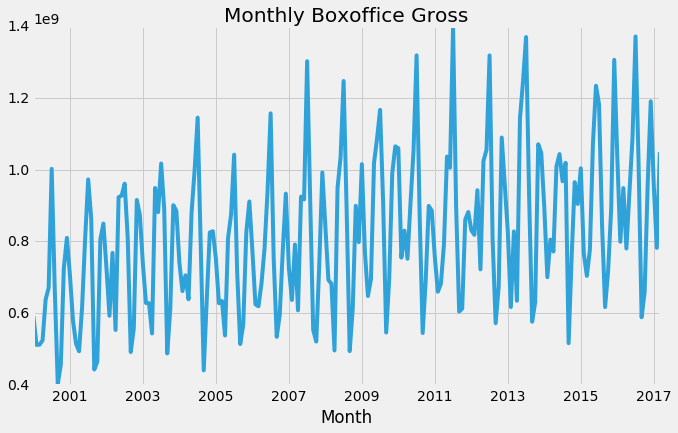

In [5]:
data.Total_Gross.plot(figsize=(10,6), title= 'Monthly Boxoffice Gross', fontsize=14)

# Step 2: Stationarize the series 

Check Stationarity
* constant mean
* constant variance
* autocovariance independent of time

Define a function for testing the mean and variance:

In [6]:
import matplotlib.pylab as plt

def test_stationarity(timeseries):
    #Determine rolling mean and standard dev
    rolling_mean = timeseries.rolling(window=12,center=False).mean()
    rolling_std = timeseries.rolling(window=12,center=False).std()
    
    #Plot statistics:
    window = plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    series = plt.plot(timeseries, label='Series')
    mean = plt.plot(rolling_mean, label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Mean')
    plt.subplot(1, 2, 2)
    series = plt.plot(timeseries, label='Series')
    std = plt.plot(rolling_std, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

Plot raw timeseries data -- total gross

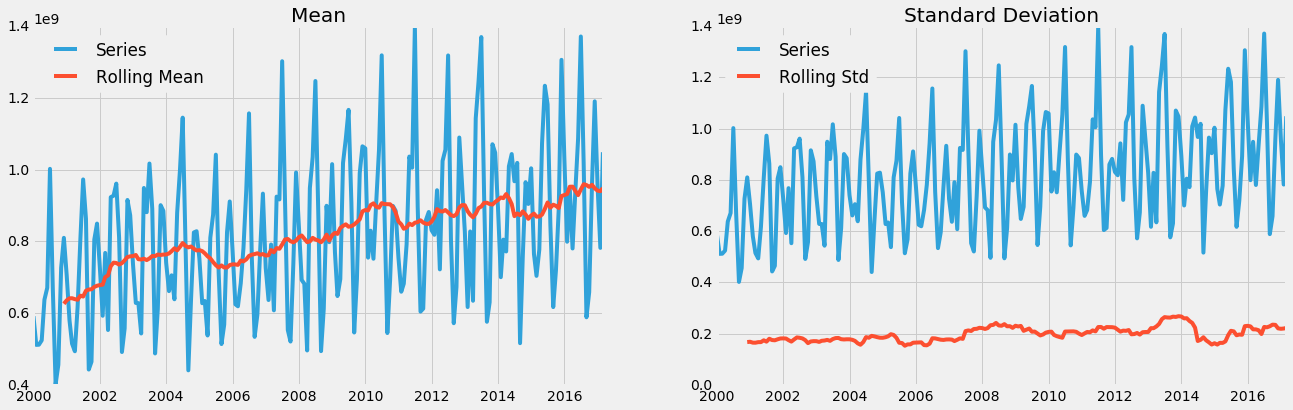

Results of Dickey-Fuller Test:
Test Statistic                  -1.704901
p-value                          0.428589
#Lags Used                      11.000000
Number of Observations Used    195.000000
Critical Value (5%)             -2.876479
Critical Value (1%)             -3.464337
Critical Value (10%)            -2.574733
dtype: float64


In [7]:
test_stationarity(data.Total_Gross)

Test different plots for stationarity:
* Log of gross sales
* First difference of gross sales
* First difference of log of gross sales
* Seasonal difference of gross sales
* Seasonal difference of log of gross sales

Take **log of timeseries** 

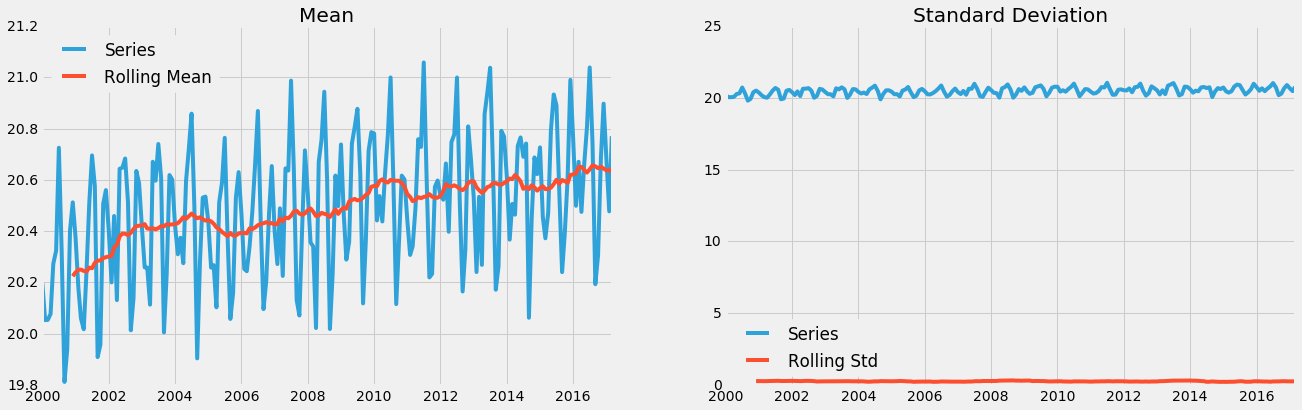

Results of Dickey-Fuller Test:
Test Statistic                  -2.170342
p-value                          0.217185
#Lags Used                      11.000000
Number of Observations Used    195.000000
Critical Value (5%)             -2.876479
Critical Value (1%)             -3.464337
Critical Value (10%)            -2.574733
dtype: float64


In [8]:
#log transform to penalizes higher values over small values
data.gross_log = data.Total_Gross.apply(lambda x: np.log(x))  
data.gross_log.dropna()
test_stationarity(data.gross_log)

Take **first difference** of the log transformed data

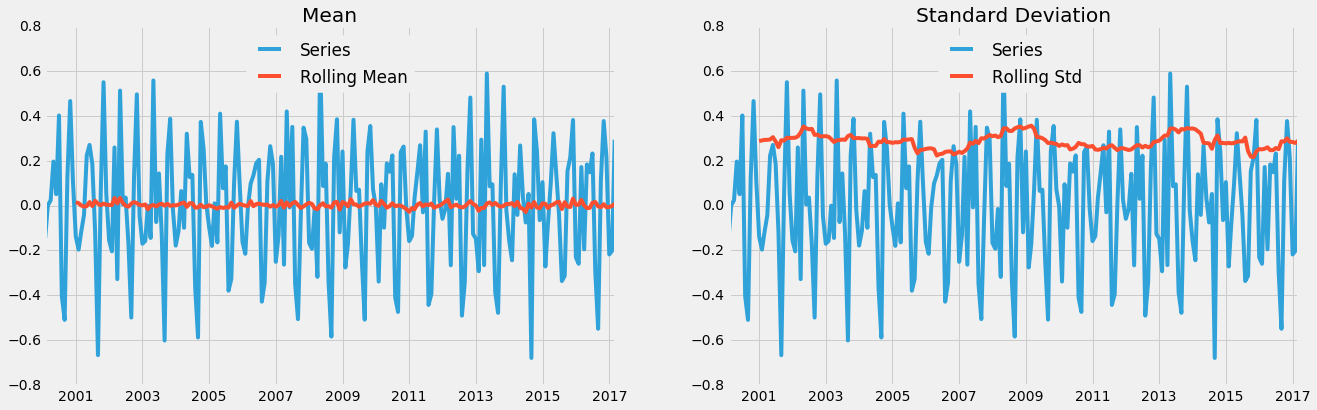

Results of Dickey-Fuller Test:
Test Statistic                -9.681726e+00
p-value                        1.199661e-16
#Lags Used                     1.100000e+01
Number of Observations Used    1.940000e+02
Critical Value (5%)           -2.876556e+00
Critical Value (1%)           -3.464515e+00
Critical Value (10%)          -2.574775e+00
dtype: float64


In [9]:
data.first_difference = data.gross_log - data.gross_log.shift(1)
data.first_difference = data.first_difference.dropna()
test_stationarity(data.first_difference)

Let's also look at the **seasonal shift** of the log transformed data

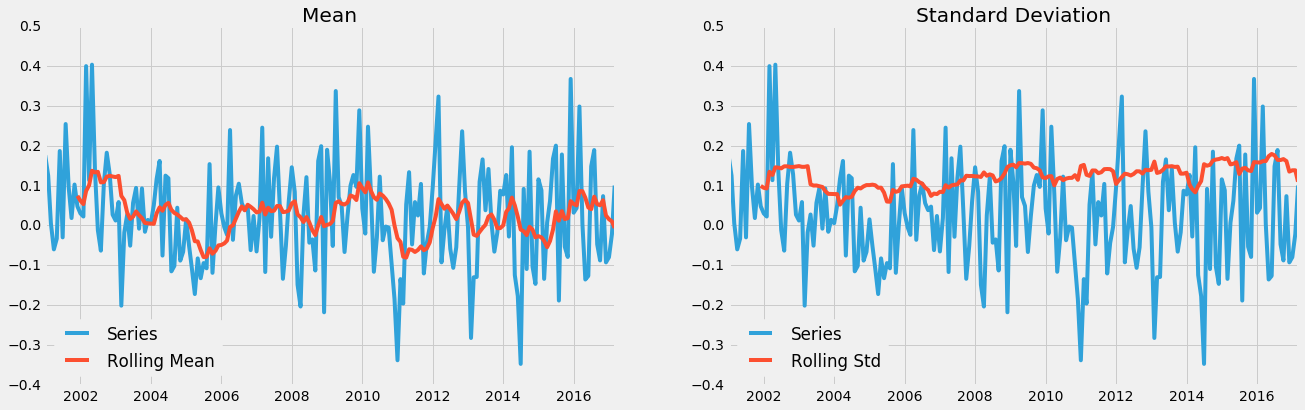

Results of Dickey-Fuller Test:
Test Statistic                  -5.411848
p-value                          0.000003
#Lags Used                      12.000000
Number of Observations Used    182.000000
Critical Value (5%)             -2.877555
Critical Value (1%)             -3.466800
Critical Value (10%)            -2.575308
dtype: float64


In [10]:
data.seasonal_shift = data.gross_log - data.gross_log.shift(12)
data.seasonal_shift = data.seasonal_shift.dropna()
test_stationarity(data.seasonal_shift)

Visually and based on the results of the augemented Dickey-Fuller Test, we that the first difference of log transformed timeseries is stationary because the p-value is very small (the log is not that much smaller) ; we also see that the Test Statistic is less than 1% critical value, which means that the time series is stationary with 99% confidence

# Step 3: Plot ACF/PACF charts and find optimal parameters

ACF measures correlation of timeseries to a lagged version of itself

PACF measures correlation of timeseries to a lagged version of itself, after removing variations explained by timestamps in between

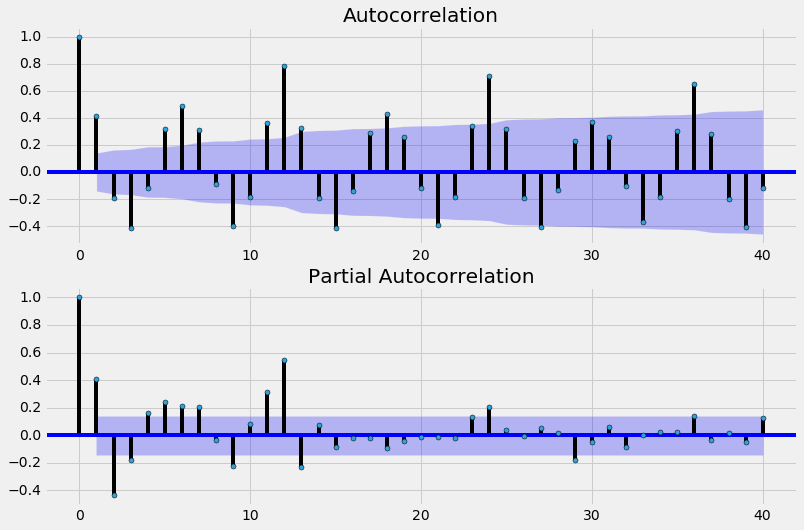

In [69]:
full_window = plt.figure(figsize=(12,8))
acf_window = full_window.add_subplot(211)
acf_plot = sm.graphics.tsa.plot_acf(data.gross_log.iloc[13:], lags=40, ax=acf_window)
pacf_window = full_window.add_subplot(212)
pacf_plot = sm.graphics.tsa.plot_pacf(data.gross_log.iloc[13:], lags=40, ax=pacf_window)

* We notice that in the regular part there is a decay in the AR structure, whereas lags 12,24,36 show a slow decay in the coefficients. This indicates the need for a 12 period seasonal component. 
* Spike at 1 in the ACF indicates an MA(1) term.
* Spike at 1 in the PACF indicates an AR(1) term.
* Spikes across 1,13,25 in the ACF indicate seasonal MA(1) terms.
* Spikes across 1,13 in the PACF may indicate seasonal AR(1) term. We will test both 1 and 0.
* Since the Dickey_Fuller test indicates we should take the first difference of the data, we will test d=0 and d=1.

* ARIMA(p, d, q) Ã— (P, D, Q)S
* p = non-seasonal AR order
* d = non-seasonal differencing
* q = non-seasonal MA order
* P = seasonal AR order
* D = seasonal differencing
* Q = seasonal MA order
* S = time span of repeating seasonal pattern.

We will test :
    * SARIMA(1,0,1) x (1,0,1,12)
    * SARIMA(1,0,0) x (1,0,1,12)
    * SARIMA(1,1,1) x (1,0,1,12)
    * SARIMA(1,1,0) x (1,0,1,12)

In [77]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

params =[(1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

seasonal_params =[(1,0,1,12)]

for param in params:
    for param_seasonal in seasonal_params:
        try:
            model = sm.tsa.statespace.SARIMAX(data.gross_log,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(1, 0, 0)x(1, 0, 1, 12) - AIC:-315.866285945
SARIMAX(1, 0, 1)x(1, 0, 1, 12) - AIC:-322.310969296
SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:-257.269726587
SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC:-311.01815735


SARIMAX(1, 0, 1)x(1, 0, 1, 12) has the lowest AIC so we will implement this model.

# Step 4: Build the SARIMA model

In [78]:
SARIMA_model = sm.tsa.statespace.SARIMAX(data.gross_log,
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = SARIMA_model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8952      0.058     15.392      0.000       0.781       1.009
ma.L1         -0.8534      0.082    -10.384      0.000      -1.014      -0.692
ar.S.L12       1.0009      0.000   8646.891      0.000       1.001       1.001
ma.S.L12      -0.9683      0.240     -4.039      0.000      -1.438      -0.498
sigma2         0.0090      0.002      4.147      0.000       0.005       0.013


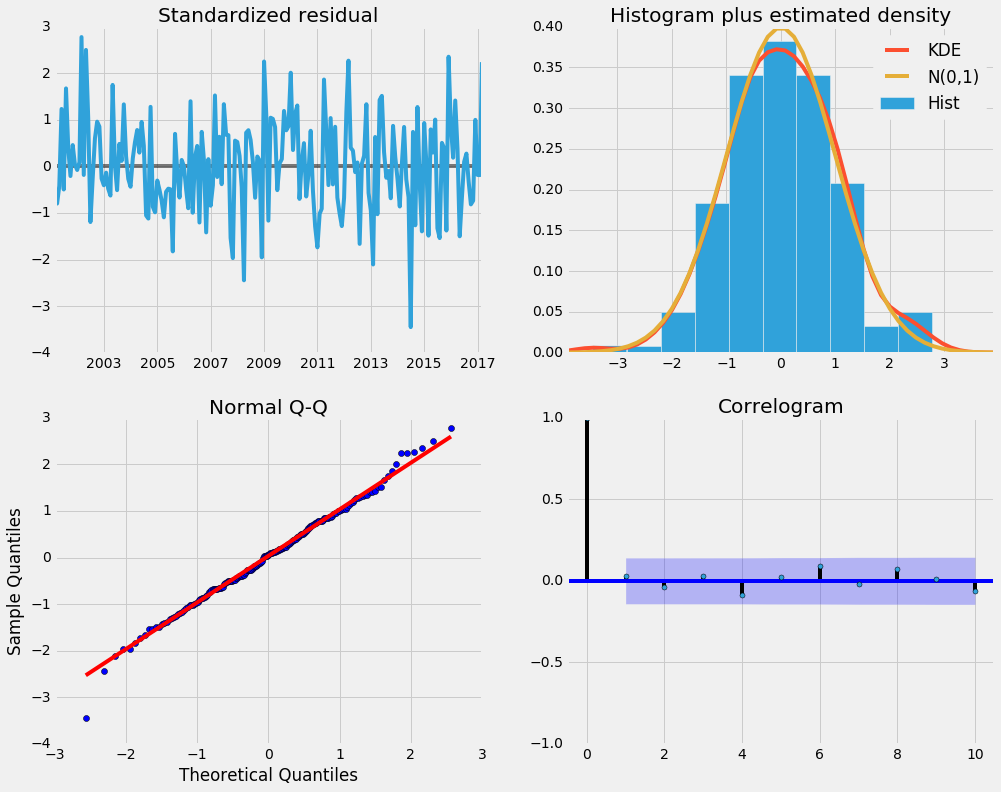

In [79]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Now create a prediction and compare it to the empirical data

In [89]:
prediction = results.get_prediction(start=pd.to_datetime('2015-08-01'), dynamic=False)

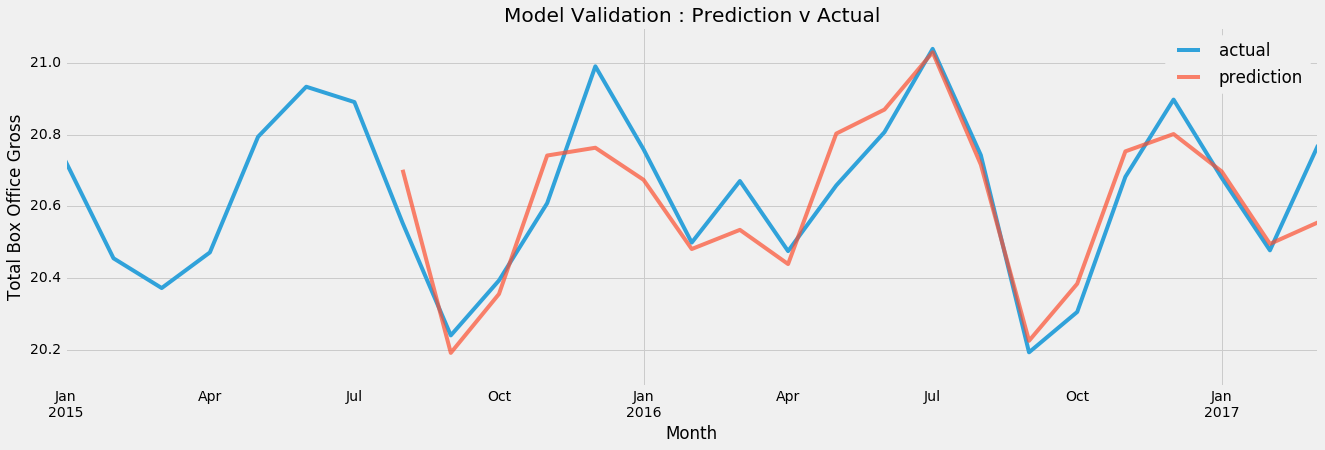

In [90]:
window = plt.figure(figsize=(20, 6))
axis = data.gross_log['2015':'2017'].plot(label='actual')
prediction.predicted_mean.plot(ax=axis, label='prediction', alpha=.7)
axis.set_title('Model Validation : Prediction v Actual')
axis.set_xlabel('Month')
axis.set_ylabel('Total Box Office Gross')
plt.legend(loc = 'best')
plt.show()

In [95]:
# Get forecast 12 steps ahead in future
prediction = results.get_forecast(steps=36)

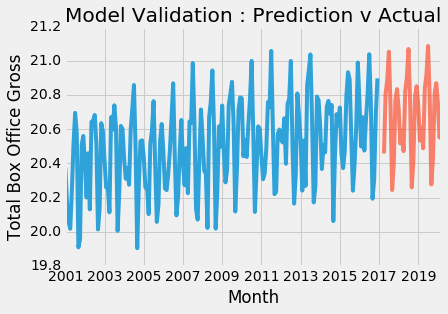

In [99]:
axis = data.gross_log['2001':'2016'].plot(label='actual')
prediction.predicted_mean.plot(ax=axis, label='prediction', alpha=.7)

axis.set_title('Model Validation : Prediction v Actual')
axis.set_xlabel('Month')
axis.set_ylabel('Total Box Office Gross')

plt.show()